This notebook combines several snippets from blog posts and notebooks about dataset exploration and basic feature analysis. Eventually it is meant to be reusable for such purposes.

The data was downloaded from https://www.kaggle.com/mmaelicke/when-is-it-worth-doing-sports-this-week/data. It combines Garmin GPS data and weather forecasts to predict how much running will be done on a given day depending on the weather.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime as dt
from datetime import timedelta as td
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.exceptions import UndefinedMetricWarning

In [6]:
import sklearn.preprocessing as preprocessing

In [7]:
df = pd.read_csv('../data/activities/activities.csv')
df.shape

(155, 47)

In [8]:
df.head()

,Activity ID,Activity Name,Description,Begin Timestamp,Begin Timestamp (Raw Milliseconds),End Timestamp,End Timestamp (Raw Milliseconds),Device,Activity Parent,Activity Type,...,Elevation Gain,Elevation Gain (Raw),Elevation Loss,Elevation Loss (Raw),Temperature (Raw),Wind Speed (Raw),Wind Direction,Humidity (Raw),Condition,Rainfall
0,2284658991,Freiburg im Breisgau Laufen,NaN,"Sa, Nov 4, 2017 12:07",1509793643000,"Sa, Nov 4, 2017 13:06",1509797186000,vívoactive HR 4.0.0.0,Beliebiger Aktivitätstyp,Laufen,...,315 Meter,315.0,314 Meter,314.0,13.9,11.0,S,77.0,fair,no
1,2284658936,Freiburg im Breisgau Laufen,NaN,"Fr, Nov 3, 2017 9:47",1509698845000,"Fr, Nov 3, 2017 10:35",1509701727000,vívoactive HR 4.0.0.0,Beliebiger Aktivitätstyp,Laufen,...,245 Meter,245.0,244 Meter,244.0,11.1,3.0,N,100.0,fair,no
2,2228102647,Freiburg im Breisgau Laufen,NaN,"Mi, Okt 25, 2017 16:31",1508941914000,"Mi, Okt 25, 2017 17:11",1508944273000,vívoactive HR 4.0.0.0,Beliebiger Aktivitätstyp,Laufen,...,208 Meter,208.0,272 Meter,272.0,20.0,6.0,SSW,60.0,fair,no
3,2104984694,Freiburg im Breisgau Laufen,NaN,"Fr, Okt 13, 2017 11:53",1507888391000,"Fr, Okt 13, 2017 12:41",1507891281000,vívoactive HR 4.0.0.0,Beliebiger Aktivitätstyp,Laufen,...,246 Meter,246.0,244 Meter,244.0,17.2,5.0,SSO,72.0,fair,no
4,2084195352,Freiburg im Breisgau Laufen,NaN,"Mo, Okt 2, 2017 14:51",1506948664000,"Mo, Okt 2, 2017 15:38",1506951524000,vívoactive HR 4.0.0.0,Beliebiger Aktivitätstyp,Laufen,...,246 Meter,246.0,240 Meter,240.0,17.8,19.0,SW,77.0,mostly cloudy,no


In [9]:
df.describe()

,Activity ID,Description,Begin Timestamp (Raw Milliseconds),End Timestamp (Raw Milliseconds),Max. Elevation (Raw),Begin Latitude (Decimal Degrees Raw),Begin Longitude (Decimal Degrees Raw),End Latitude (Decimal Degrees Raw),End Longitude (Decimal Degrees Raw),Max. Heart Rate (bpm),...,Moving Duration (Raw Seconds),Average Speed (Raw),Distance (Raw),Max. Heart Rate (bpm).1,Min. Elevation (Raw),Elevation Gain (Raw),Elevation Loss (Raw),Temperature (Raw),Wind Speed (Raw),Humidity (Raw)
count,1.550000e+02,0.0,1.550000e+02,1.550000e+02,155.000000,39.000000,39.000000,39.000000,39.000000,91.000000,...,1.550000e+02,155.000000,155.000000,91.000000,155.000000,155.000000,155.000000,150.000000,149.000000,150.000000
mean,1.534023e+09,NaN,1.482598e+12,1.482891e+12,383.125613,48.024921,7.826712,48.025003,7.819512,194.681319,...,2.899298e+04,5.945778,26.776991,96.901099,383.125613,158.055097,158.407484,18.171333,9.946309,65.333333
std,2.847469e+08,NaN,1.522668e+10,1.443544e+10,117.063615,0.039057,0.115354,0.038942,0.112326,5.380787,...,2.332899e+05,0.960392,251.049566,12.642130,117.063615,119.421463,118.436687,7.032736,5.700623,17.810964
min,9.083326e+08,NaN,1.420080e+12,1.443093e+12,159.800000,48.008097,7.534500,48.009655,7.535721,179.000000,...,9.440000e+02,4.792026,2.701190,70.000000,159.800000,3.000000,3.000000,-2.800000,2.000000,26.000000
25%,1.297725e+09,NaN,1.470822e+12,1.470825e+12,307.245000,48.017743,7.856372,48.019321,7.855891,191.000000,...,1.603500e+03,5.414772,5.016340,89.000000,307.245000,70.000000,70.095000,13.900000,5.000000,52.250000
50%,1.449839e+09,NaN,1.479311e+12,1.479313e+12,326.680000,48.019178,7.856927,48.019381,7.855951,194.000000,...,2.259000e+03,5.889282,6.107940,96.000000,326.680000,134.500000,132.610000,18.900000,10.000000,63.000000
75%,1.743754e+09,NaN,1.495106e+12,1.495109e+12,456.705000,48.019887,7.873379,48.019417,7.856061,198.000000,...,2.929500e+03,6.228244,7.773235,101.500000,456.705000,217.270000,218.110000,22.800000,13.000000,77.000000
max,2.284659e+09,NaN,1.509794e+12,1.509797e+12,756.600000,48.261844,7.984675,48.261721,7.984625,208.000000,...,2.094296e+06,14.232849,3132.000000,143.000000,756.600000,622.000000,624.000000,32.800000,27.000000,100.000000


In [10]:
df['time'] = (df['End Timestamp (Raw Milliseconds)'] - df['Begin Timestamp (Raw Milliseconds)']) / 1000

Getting rid of outliers

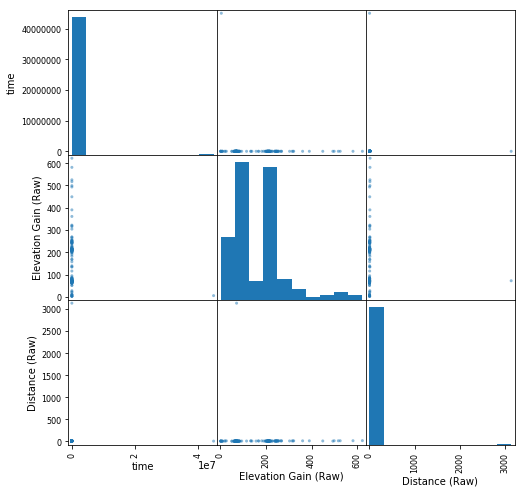

In [11]:
scatter_matrix(df[['time', 'Elevation Gain (Raw)', 'Distance (Raw)']], figsize=(8,8));

In [24]:
df = df[~(df['Distance (Raw)'] > 1000)]
df = df[~(df['time'] > 100000)]

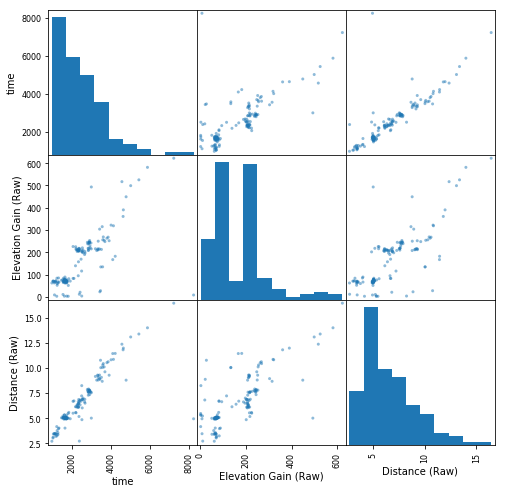

In [56]:
scatter_matrix(df[['time', 'Elevation Gain (Raw)', 'Distance (Raw)']], figsize=(8,8));

Add day of the week and hour of day features, remove nans

In [26]:
data = df[['Activity ID', 'Activity Name']].copy()
data.columns = ['id', 'name']

# date
data['date'] = df['Begin Timestamp (Raw Milliseconds)'].apply(lambda i: dt.fromtimestamp(i / 1000))

# distance, time, elevation gain
data['time'] = df['time']
data['distance'] = df['Distance (Raw)']
data['elevation_gain'] = df['Elevation Gain (Raw)']

# day of the week with Monday=0
data['dow'] = df['Begin Timestamp (Raw Milliseconds)'].apply(lambda i: dt.fromtimestamp(i / 1000).weekday())

# hour of day 
data['hod'] = df['Begin Timestamp (Raw Milliseconds)'].apply(lambda i: dt.fromtimestamp(i / 1000).hour)

# temperature, wind speed, wind direction, humidity, condition, rainfall
data['temperature'] = df['Temperature (Raw)']
data['wind_speed'] = df['Wind Speed (Raw)']
data['wind_direction'] = df['Wind Direction']
data['humidity'] = df['Humidity (Raw)']
data['sky'] = df['Condition']
data['rainfall'] = df['Rainfall'].map({'no': 0, 'yes':1})

In [27]:
print('Dataset length: %d:\n' % len(data), data.isnull().sum())
data.dropna(axis=0, how='any', inplace=True)
print('After Cleanup: %d\n' % len(data), data.isnull().sum())
data = data.copy()
data.head()

Dataset length: 153:
 id                0
name              0
date              0
time              0
distance          0
elevation_gain    0
dow               0
hod               0
temperature       4
wind_speed        5
wind_direction    5
humidity          4
sky               4
rainfall          4
dtype: int64
After Cleanup: 148
 id                0
name              0
date              0
time              0
distance          0
elevation_gain    0
dow               0
hod               0
temperature       0
wind_speed        0
wind_direction    0
humidity          0
sky               0
rainfall          0
dtype: int64


,id,name,date,time,distance,elevation_gain,dow,hod,temperature,wind_speed,wind_direction,humidity,sky,rainfall
0,2284658991,Freiburg im Breisgau Laufen,2017-11-04 14:07:23,3543.0,8.66881,315.0,5,14,13.9,11.0,S,77.0,fair,0.0
1,2284658936,Freiburg im Breisgau Laufen,2017-11-03 11:47:25,2882.0,7.62835,245.0,4,11,11.1,3.0,N,100.0,fair,0.0
2,2228102647,Freiburg im Breisgau Laufen,2017-10-25 17:31:54,2359.0,6.60755,208.0,2,17,20.0,6.0,SSW,60.0,fair,0.0
3,2104984694,Freiburg im Breisgau Laufen,2017-10-13 12:53:11,2890.0,7.75709,246.0,4,12,17.2,5.0,SSO,72.0,fair,0.0
4,2084195352,Freiburg im Breisgau Laufen,2017-10-02 15:51:04,2860.0,7.81321,246.0,0,15,17.8,19.0,SW,77.0,mostly cloudy,0.0


Look back 5 days and add "load" featurs

In [70]:
data['load_amount'], data['load_hours'], data['load_gain'] = np.nan, np.nan, np.nan
for i,row in data.iterrows():
    start = (row.date - td(5)).date()
    extract = data[np.logical_and(data.date < row.date,  data.date > start)]
    
    # was there a activity
    if extract.empty:
        data.loc[i, 'load_amount'] = 0
        data.loc[i, 'load_hours'] = 0
        data.loc[i, 'load_gain'] = 0
    else:
        data.loc[i, 'load_amount'] = len(extract)
        data.loc[i, 'load_hours'] = extract.time.sum() / 3600
        data.loc[i, 'load_gain'] = extract.elevation_gain.sum()
    
data.head()

,id,name,date,time,distance,elevation_gain,dow,hod,temperature,wind_speed,wind_direction,humidity,sky,rainfall,load_amount,load_hours,load_gain,target,wind_direction_int,sky_int
0,2284658991,Freiburg im Breisgau Laufen,2017-11-04 14:07:23,3543.0,8.66881,315.0,5,14,13.9,11.0,S,77.0,fair,0.0,1.0,0.800556,245.0,2.0,7,1
1,2284658936,Freiburg im Breisgau Laufen,2017-11-03 11:47:25,2882.0,7.62835,245.0,4,11,11.1,3.0,N,100.0,fair,0.0,0.0,0.000000,0.0,1.0,0,1
2,2228102647,Freiburg im Breisgau Laufen,2017-10-25 17:31:54,2359.0,6.60755,208.0,2,17,20.0,6.0,SSW,60.0,fair,0.0,0.0,0.000000,0.0,1.0,10,1
3,2104984694,Freiburg im Breisgau Laufen,2017-10-13 12:53:11,2890.0,7.75709,246.0,4,12,17.2,5.0,SSO,72.0,fair,0.0,0.0,0.000000,0.0,1.0,9,1
4,2084195352,Freiburg im Breisgau Laufen,2017-10-02 15:51:04,2860.0,7.81321,246.0,0,15,17.8,19.0,SW,77.0,mostly cloudy,0.0,2.0,1.872500,491.0,1.0,11,5


Apply regression to predict time from distance, use the regressor to engineer the target values

In [29]:
x = data.distance.values
y = data.time.values


lm2 = LinearRegression()
lm2.fit(x.reshape(-1,1), y.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
Y_ = lm2.predict(x.reshape(-1,1))

# lower 0.95                     ==> good, 0
# lower 1.05 and not lower 0.95  ==> fair, 1
# higher 1.05                    ==> poor, 2
l95 = y < 0.95 * Y_.flatten()
l105 = y < 1.05 * Y_.flatten()
h105 = y > 1.05 * Y_.flatten()


labels = y.copy()

labels[l95] = 0
labels[np.logical_and(l105, ~l95)] = 1
labels[h105] = 2

print(labels)

[2. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 1. 0. 0. 0. 0. 0. 1. 1. 1. 2. 1. 1.
 1. 2. 2. 2. 1. 2. 2. 2. 1. 1. 1. 2. 1. 1. 0. 2. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 2. 1.
 0. 2. 1. 0. 1. 0. 1. 0. 1. 0. 2. 2. 1. 1. 2. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 2. 1. 2.]


In [31]:
X = np.linspace(np.min(x), np.max(x), 1000)
Y = lm2.predict(X.reshape(1000, 1))

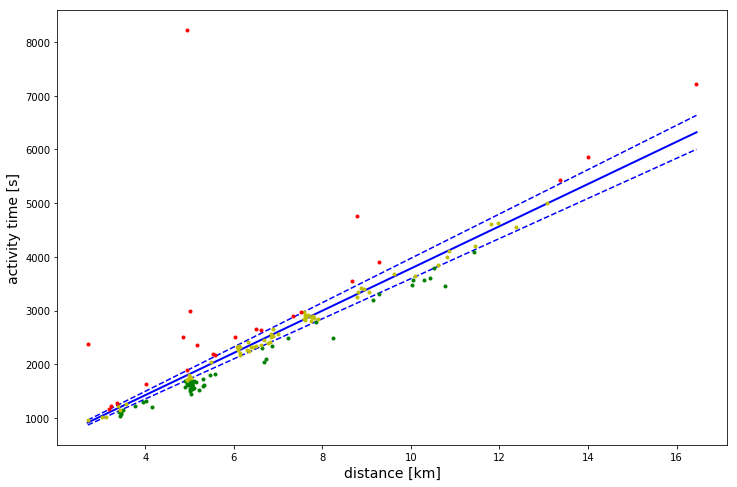

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(X, Y, '-b', lw=2)
ax.set_xlabel('distance [km]', fontsize=14)
ax.set_ylabel('activity time [s]', fontsize=14)
ax.plot(X, Y * 1.05, '--b')
ax.plot(X, Y * .95, '--b')

ax.plot(x[np.where(labels==0)], y[np.where(labels==0)], '.g')
ax.plot(x[np.where(labels==1)], y[np.where(labels==1)], '.y')
ax.plot(x[np.where(labels==2)], y[np.where(labels==2)], '.r');

In [33]:
data['target'] = labels

In [34]:
data.target.unique()

array([2., 1., 0.])

Number of good: 63, fair: 62, poor: 23


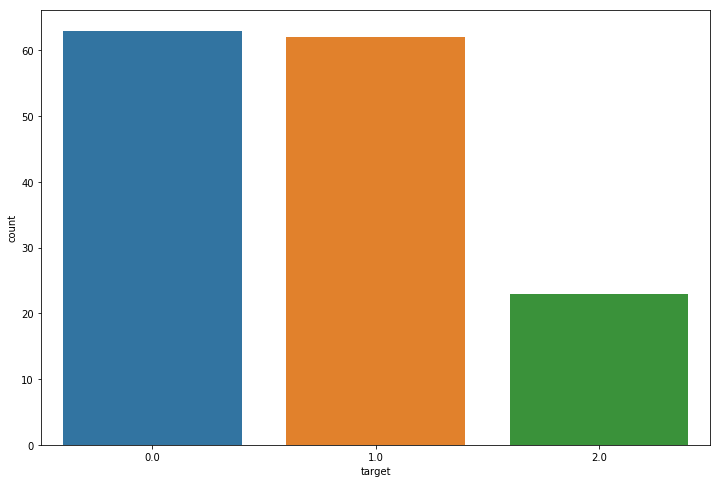

In [41]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data.target,label="count")
good, fair, poor = data.target.value_counts()
print('Number of good: {}, fair: {}, poor: {}'.format(good, fair, poor))

Encode label fields

In [42]:
data.shape, sorted(data.wind_direction.unique()), data.sky.unique()

((148, 18),
 ['N',
  'NNO',
  'NNW',
  'NO',
  'NW',
  'O',
  'OSO',
  'S',
  'SO',
  'SSO',
  'SSW',
  'SW',
  'W ',
  'WNW',
  'WSW'],
 array(['fair', 'mostly cloudy', 'mostly clear', 'showers',
        'partly cloudy', 'cloudy', 'thunderstorm', 'light rain', 'mist',
        'rain'], dtype=object))

In [43]:
data['wind_direction_int'] = preprocessing.LabelEncoder().fit_transform(data.wind_direction)

In [44]:
# le = preprocessing.LabelEncoder().fit(['fair', 'mostly clear', 'partly cloudy', 'mostly cloudy', 'cloudy',
#                                        'mist', 'light rain', 'rain', 'showers', 'thunderstorm'])
# le.set_params...

data['sky_int'] = preprocessing.LabelEncoder().fit_transform(data.sky)

In [45]:
data.sky_int.values

array([1, 1, 1, 1, 5, 5, 4, 1, 8, 1, 1, 5, 5, 8, 1, 1, 1, 6, 4, 4, 1, 1,
       0, 1, 1, 5, 4, 1, 5, 6, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 9, 1, 5, 4,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 1, 1, 1, 4, 4, 2, 6, 3, 0,
       0, 1, 3, 5, 1, 3, 5, 5, 0, 2, 1, 5, 5, 1, 1, 5, 5, 5, 6, 2, 1, 4,
       1, 4, 5, 1, 5, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 6, 4, 4, 1, 4, 1,
       5, 4, 5, 1, 5, 4, 4, 1, 4, 1, 1, 1, 1, 1, 5, 8, 6, 1, 1, 1, 4, 4,
       1, 1, 4, 4, 1, 1, 1, 4, 4, 6, 7, 0, 4, 1, 1, 4])

Normalize the dataset, use violin and box plots of features to see if means indicate which may be more useful to distinguish between good/fair activity

In [46]:
x = pd.concat([data.iloc[:,3:9], data.iloc[:,13:-3], data.iloc[:,11], data.iloc[:,-2:]],
              axis=1, join_axes=[data.index])

In [47]:
x.head()

,time,distance,elevation_gain,dow,hod,temperature,rainfall,load_amount,load_hours,load_gain,humidity,wind_direction_int,sky_int
0,3543.0,8.66881,315.0,5,14,13.9,0.0,1.0,0.800556,245.0,77.0,7,1
1,2882.0,7.62835,245.0,4,11,11.1,0.0,0.0,0.000000,0.0,100.0,0,1
2,2359.0,6.60755,208.0,2,17,20.0,0.0,0.0,0.000000,0.0,60.0,10,1
3,2890.0,7.75709,246.0,4,12,17.2,0.0,0.0,0.000000,0.0,72.0,9,1
4,2860.0,7.81321,246.0,0,15,17.8,0.0,2.0,1.872500,491.0,77.0,11,5


In [48]:
x_n_2 = (x - x.mean()) / (x.std())

In [49]:
X = pd.concat([data.target[data.target < 2. ], x_n_2[data.target < 2.]], axis=1)

In [50]:
X.head()

,target,time,distance,elevation_gain,dow,hod,temperature,rainfall,load_amount,load_hours,load_gain,humidity,wind_direction_int,sky_int
1,1.0,0.380166,0.415958,0.713832,0.312191,-0.960392,-0.992942,-0.282399,-1.544922,-1.390911,-1.222863,1.939347,-1.100089,-0.786613
2,1.0,-0.069717,0.011729,0.407640,-0.692251,1.009188,0.272567,-0.282399,-1.544922,-1.390911,-1.222863,-0.308291,1.070754,-0.786613
3,1.0,0.387047,0.466938,0.722107,0.312191,-0.632129,-0.125571,-0.282399,-1.544922,-1.390911,-1.222863,0.366000,0.853669,-0.786613
4,1.0,0.361242,0.489161,0.722107,-1.696693,0.352661,-0.040256,-0.282399,0.376494,1.172085,1.457669,0.646955,1.287838,1.121891
5,1.0,0.346618,0.523723,0.664179,0.814412,1.009188,0.272567,-0.282399,-0.584214,0.091148,0.152889,-0.083527,-0.665921,1.121891


In [52]:
X = pd.melt(X, id_vars='target', var_name='features', value_name='value')

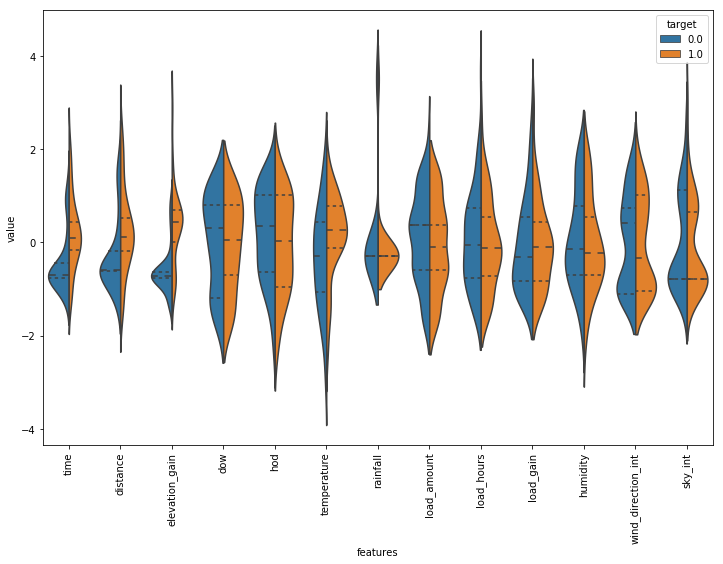

In [54]:
plt.figure(figsize=(12,8))
sns.violinplot(x='features', y='value', hue='target', data=X, split=True, inner='quart')
plt.xticks(rotation=90);

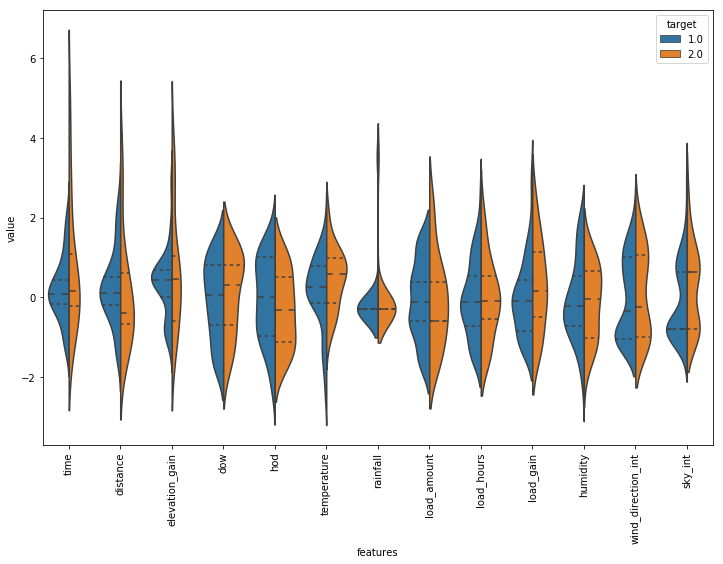

In [58]:
X = pd.concat([data.target[data.target > 0. ], x_n_2[data.target > 0.]], axis=1)
X = pd.melt(X, id_vars='target', var_name='features', value_name='value')

plt.figure(figsize=(12,8))
sns.violinplot(x='features', y='value', hue='target', data=X, split=True, inner='quart')
plt.xticks(rotation=90);

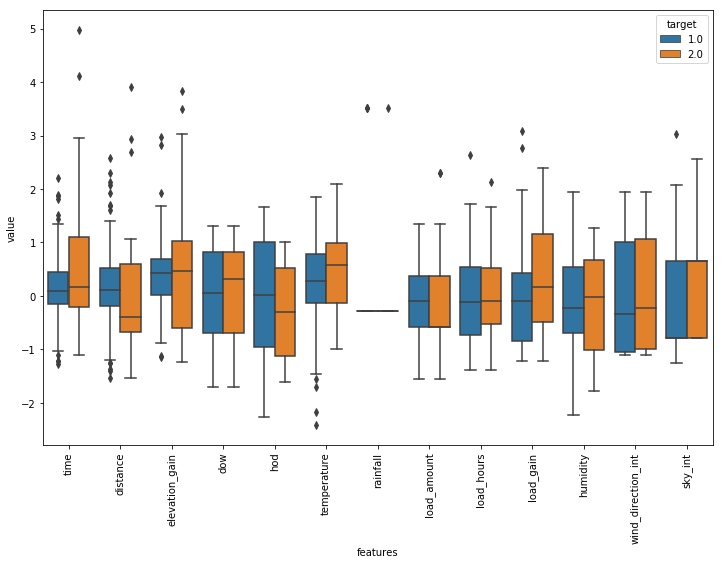

In [60]:
# As an alternative of violin plot, box plot can be used
# box plots are also useful in terms of seeing outliers
# I do not visualize all features with box plot
# In order to show you lets have an example of box plot
# If you want, you can visualize other features as well.
plt.figure(figsize=(12,8))
sns.boxplot(x='features', y='value', hue='target', data=X)
plt.xticks(rotation=90);

A closer look at feature correlation

In [67]:
x_n_2.columns, x_n_2.shape, len(labels)

(Index(['time', 'distance', 'elevation_gain', 'dow', 'hod', 'temperature',
        'rainfall', 'load_amount', 'load_hours', 'load_gain', 'humidity',
        'wind_direction_int', 'sky_int'],
       dtype='object'), (148, 13), 148)

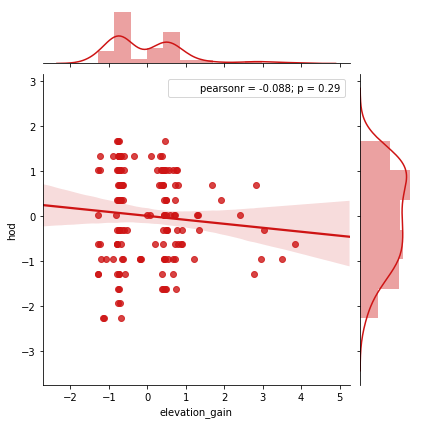

In [65]:
sns.jointplot(x_n_2.loc[:,'elevation_gain'], x_n_2.loc[:,'hod'], kind='regg', color='#ce1414');

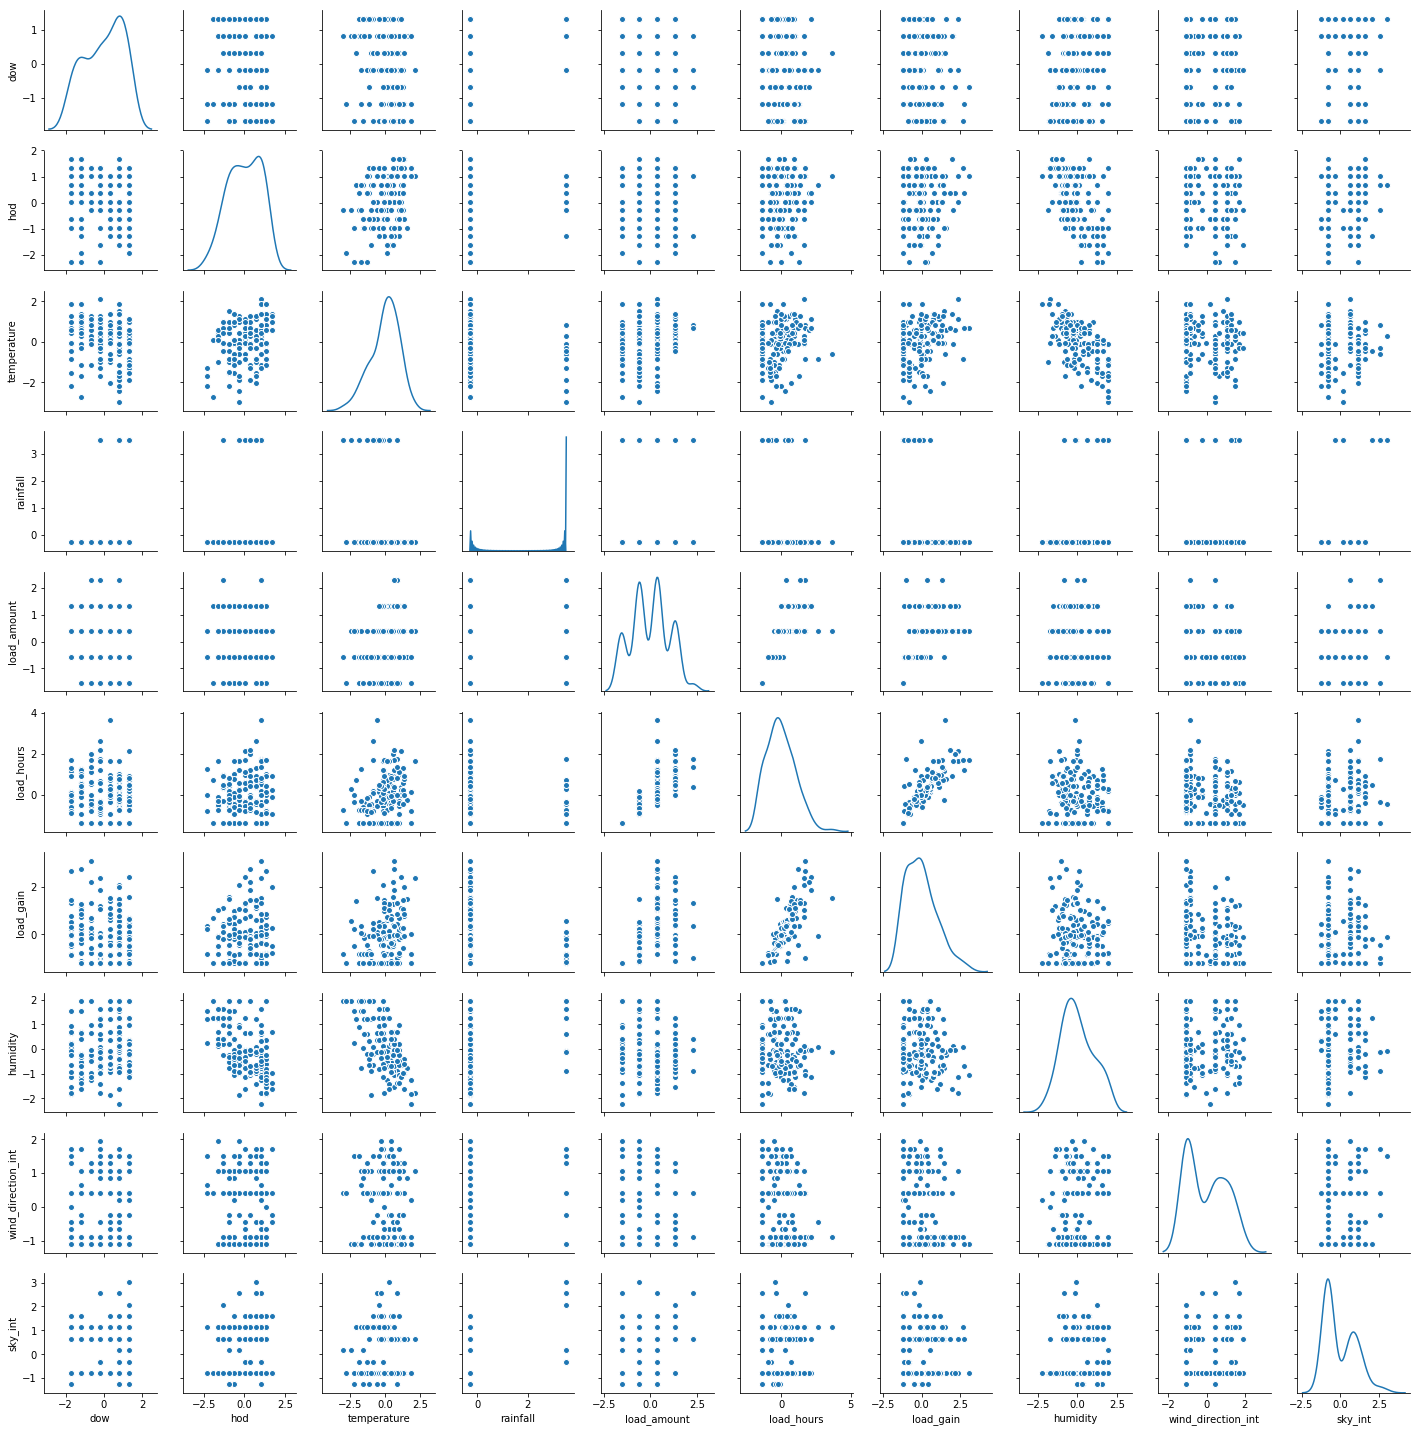

In [89]:
ax = sns.pairplot(x_n_2.iloc[:, 3:], diag_kind='kde', size=2)

Use RandomForestClassifier to measure relative importance of features so far.

> RandomForest randomly generates a thousands of decision trees. As the trees are randomly generated, the algorithm takes turns leaving out each variable in fitting the model. This allows the RandomForest to calculate just how much worse a model does when each variable is left out.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(x_n_2.iloc[:, 3:], labels,
                                                    test_size=0.2, stratify=labels, random_state=42)

print('Using %d training and %d test sets' % (len(X_train), len(X_test)))

Using 118 training and 30 test sets


In [91]:
randomForest = RandomForestClassifier(random_state=42)

param_grid = [
    dict(n_estimators=[3,5,10,30], max_depth=[2,3,5,7], criterion=['gini', 'entropy']),
    dict(n_estimators=[3,5,10,30], max_depth=[2,3,5,7], criterion=['gini', 'entropy'], bootstrap=[False])
]

searcher = GridSearchCV(randomForest, param_grid, refit=True, 
                        scoring=metrics.make_scorer(metrics.f1_score, average='weighted')
                       )
searcher.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 5, 10, 30], 'max_depth': [2, 3, 5, 7], 'criterion': ['gini', 'entropy']}, {'n_estimators': [3, 5, 10, 30], 'max_depth': [2, 3, 5, 7], 'criterion': ['gini', 'entropy'], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [92]:
print('Parameter set:\n', searcher.best_params_)

Parameter set:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 5}


In [93]:
model = searcher.best_estimator_

# split my training data into a validation and training dataset
_X_train, _X_val, _y_train, _y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

training_errors = list()
validation_errors = list()

for m in range(1, len(_X_train)):
    model.fit(_X_train[:m], _y_train[:m])
    training_predictions = model.predict(_X_train[:m])
    validation_prediction = model.predict(_X_val)
    training_errors.append(1 - metrics.f1_score(training_predictions, _y_train[:m], average='weighted'))
    validation_errors.append(1 - metrics.f1_score(validation_prediction, _y_val, average='weighted'))

Text(0,0.5,'1 - score')

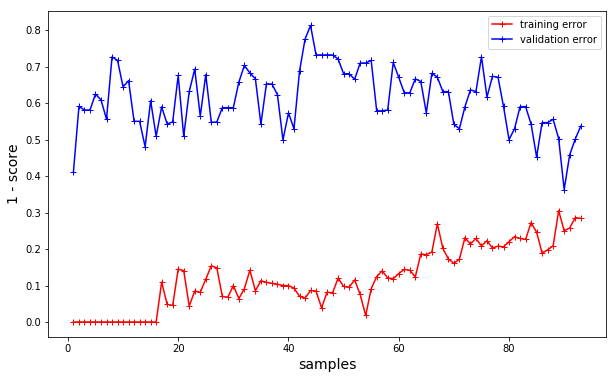

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(range(1, len(_X_train)), training_errors, '-+r', label='training error')
ax.plot(range(1, len(_X_train)), validation_errors, '-+b', label='validation error')
plt.legend(loc='upper right')
ax.set_xlabel('samples', fontsize=14)
ax.set_ylabel('1 - score',fontsize=14)

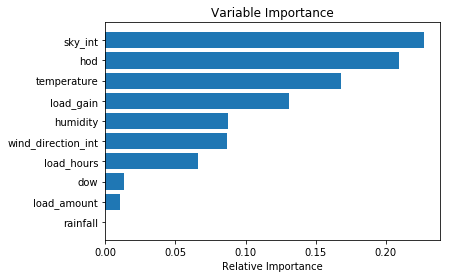

In [95]:
features = _X_train.columns
importances = model.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

Next step is feature engineering

References:
1. https://www.kaggle.com/mmaelicke/when-is-it-worth-doing-sports-this-week
2. https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
3. https://www.districtdatalabs.com/visual-diagnostics-for-more-informed-machine-learning-part-2
4. http://blog.yhat.com/tutorials/5-Feature-Engineering.html